# Best Staying Location for Tourists

If you're visiting a new city to explore, selecting a location for your hotel/villa is difficult so as to minimize your intercity travel time and cost such that your time is utilized in the right manner and not in travelling most of the time. This problem arises especially in cities like Mumbai where travelling small distances take a lot of time.

This project will help users to choose areas where most of the tourist locations lie and hence making it easy to choose their staying location

## Gathering Data

We use FourSquare API to get "Popular with Visitors" places in Mumbai, Maharashtra

In [1]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore?v=20170511&client_id=W3ZTSV3R43FRPSAXA1HSVCEINNRG3GKNFQVJ4PKWEALLE5B3&client_secret=CC0C4TSXFM112O0ZBR2N35SKKOPAGJVI3MTZAM0TWCWQQPH4&nearGeoId=72057594039203275&q=Popular%20with%20Visitors'
resp = requests.get(url=url)
data = json.loads(resp.text)

## Data Preprocessing 

The data returned from the API call is in json format. We fetch the useful keys out of the response and convert it to a pandas dataframe. 

In [2]:
import pandas as pd
import numpy as np

C:\Users\inasu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\inasu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\inasu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
#Initializing an empty dictionary to be converted to dataframe
temp={'Name':[],'Lat':[],'Long':[],'Address':[],'Category':[]}

for i in data['response']['groups'][0]['items']:
    
    #Storing the values in variable and then appending to dictionary as direct append was causing issues!
    Name=i['venue']['name']
    Location=', '.join(i['venue']['location']['formattedAddress'])
    Lat=i['venue']['location']['lat']
    Long=i['venue']['location']['lng']
    Category=i['venue']['categories'][0]['name']
    
    #Appending the values to the respective key list
    temp['Name'].append(Name)
    temp['Address'].append(Location)
    temp['Lat'].append(Lat)
    temp['Long'].append(Long)
    temp['Category'].append(Category)
    
#Converting the list to dataframe
df= pd.DataFrame.from_dict(temp)
df.head()

,Name,Lat,Long,Address,Category
0,Taj Mahal Palace & Tower,18.922306,72.833578,Apollo Bunder (P. Jetha Singh Ramchandani Marg...,Hotel
1,Prithvi Theatre,19.106157,72.825810,"Church Road (Juhu), Mumbai 400049, Mahārāshtra...",Theater
2,Jogger's Park,19.059728,72.822055,"Carter Road (Bandra West), Mumbai 400 050, Mah...",Park
3,Nariman Point,18.929183,72.822232,"Nariman Point (Dorabji Tata Road), Mumbai 4000...",Scenic Lookout
4,Starbucks Coffee Capital,19.063457,72.861576,"The Capital, India",Coffee Shop


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      30 non-null     object 
 1   Lat       30 non-null     float64
 2   Long      30 non-null     float64
 3   Address   30 non-null     object 
 4   Category  30 non-null     object 
dtypes: float64(2), object(3)
memory usage: 1.3+ KB


### Data Cleaning : Checking For Null Values

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

We generate a heatmap to check for null values in our dataframe

<AxesSubplot:>

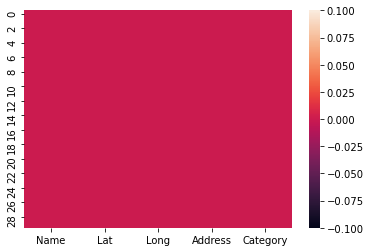

In [6]:
sns.heatmap(df.isnull())

In [7]:
df.isna().sum()

Name        0
Lat         0
Long        0
Address     0
Category    0
dtype: int64

As we observe from the heatmap above, there are no null values in our dataset. Hence we can move ahead.

## Clustering 

Now we begin Clustering of places together. We will form 3 clusters and group places that lie relatively near to each other.

In [8]:
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

C:\Users\inasu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
x1=df['Lat']
x2=df['Long']

  Using cached numpy-1.20.0-cp38-cp38-win_amd64.whl (13.7 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.4.1 requires numpy~=1.19.2, but you'll have numpy 1.20.0 which is incompatible.


In [56]:
#This function will assign the point to a cluster
color_map=np.array(['b','r','g'])
def assign_members(x1,x2,centers):
    class_of_points=[]
    color=[]
    
    #Calculating distances of all points from centroids
    to_c1=np.sqrt(np.square(np.array(x1)-centers[0][0])+np.square(np.array(x2)-centers[0][1]))
    to_c2=np.sqrt(np.square(np.array(x1)-centers[1][0])+np.square(np.array(x2)-centers[1][1]))
    to_c3=np.sqrt(np.square(np.array(x1)-centers[2][0])+np.square(np.array(x2)-centers[2][1]))
    
    #checking which centroid they are closest to, and assigning it the respective color
    for i in range(len(to_c1)):
        class_of_point = 0 if to_c1[i] < to_c2[i] and to_c1[i] < to_c3[i] else (1 if to_c3[i] > to_c2[i] else 2)
        class_of_points.append(class_of_point)
        color.append(color_map[class_of_point])
        
    colors= np.array(color)
    return colors,np.array(class_of_points)

#This function will update centroid of clusters
def update_centers(x1,x2,class_of_points):
    center1=[np.mean(np.array(x1)[class_of_points==0]),np.mean(np.array(x2)[class_of_points==0])]
    center2=[np.mean(np.array(x1)[class_of_points==1]),np.mean(np.array(x2)[class_of_points==1])]
    center3=[np.mean(np.array(x1)[class_of_points==2]),np.mean(np.array(x2)[class_of_points==2])]
    return [center1,center2,center3]

#This Function plots data points along with cluster centroids
def plot_points(centroids=None,colors='g',figure_title=None):
    fig=plt.figure(figsize=(15,10))
    ax=fig.add_subplot(1,1,1)
    
    #Plotting the centroids on the graph
    centroid_colors=['bx','rx','gx']
    if centroids:
        for (i,centroid) in enumerate(centroids):
            ax.plot(centroid[0],centroid[1],centroid_colors[i],markeredgewidth=5,markersize=20)
    
    #Drawing the scatterplot
    plt.scatter(x1,x2,s=500,c=colors)
    xticks=np.arange(-6,8,15)
    yticks=np.arange(-6,6,13)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    xlabels=xticks
    ylabels=yticks
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params('both',length=2,width=1,which='major',labelsize=15)
    ax.set_xlabel('x1',fontsize=20)
    ax.set_ylabel('x2',fontsize=20)
    ax.set_title(figure_title,fontsize=24)
    plt.show()

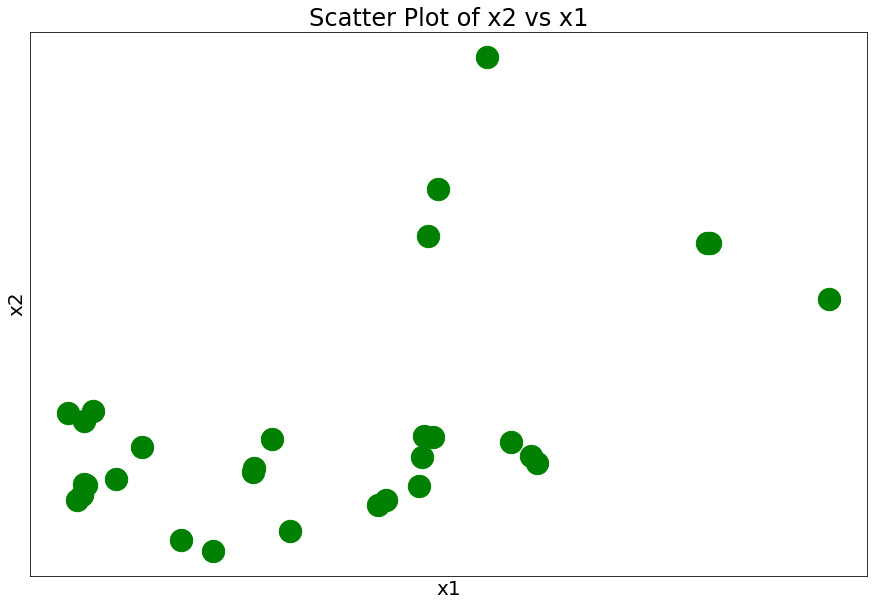

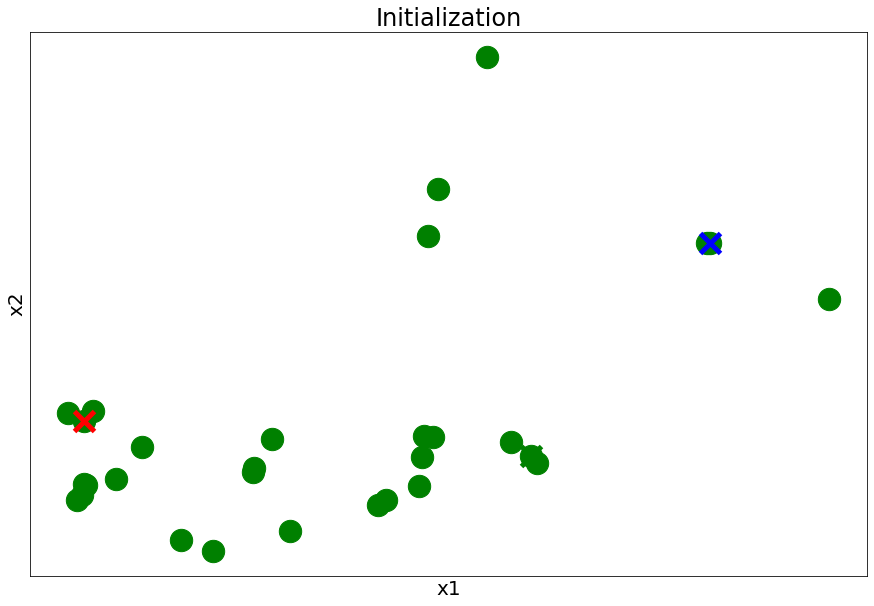

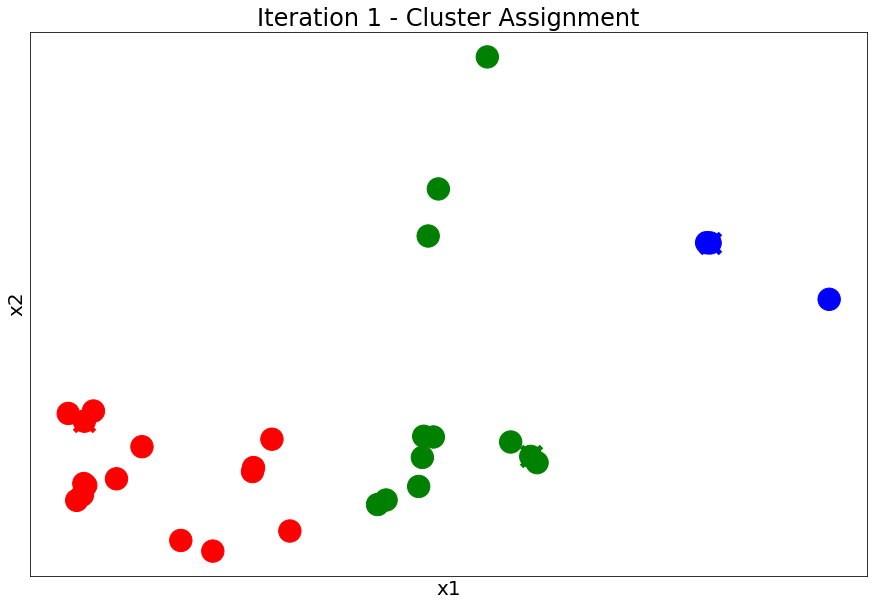

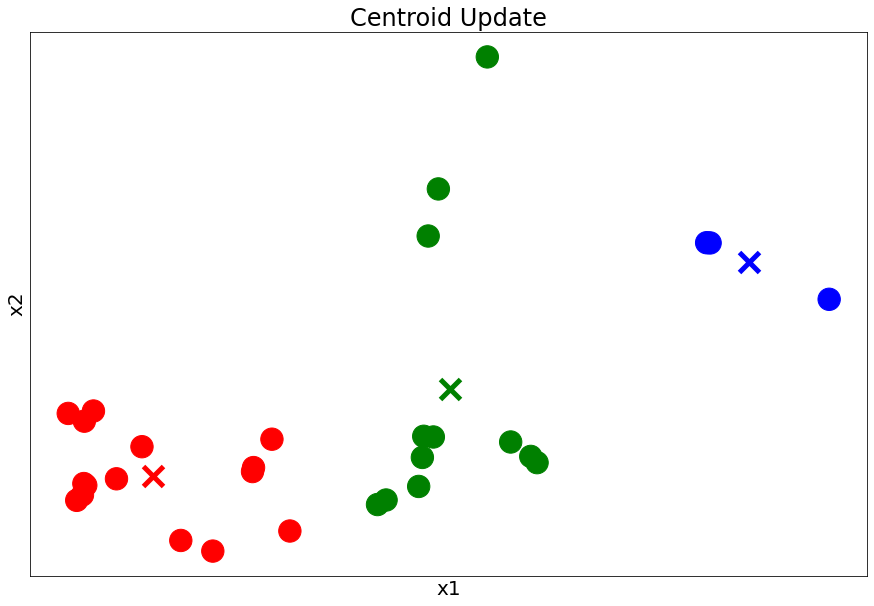

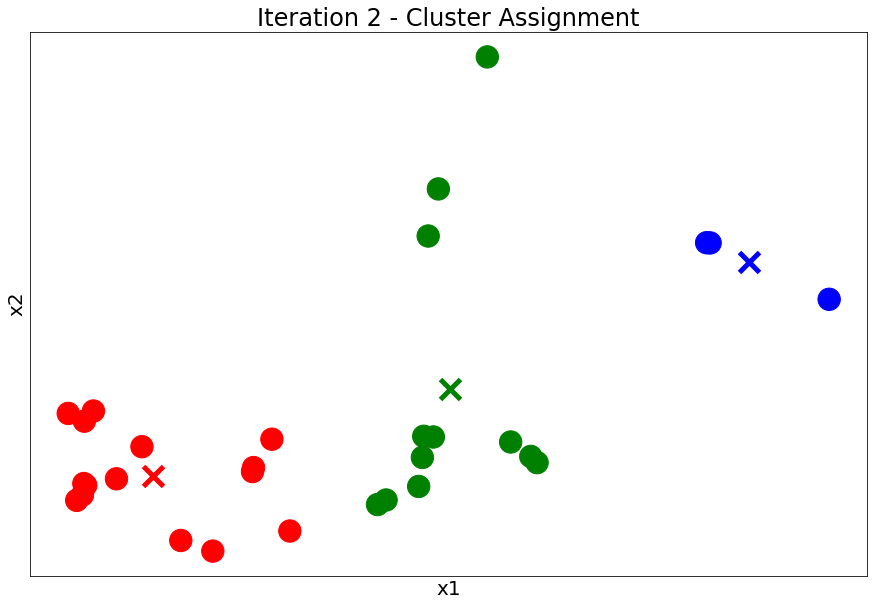

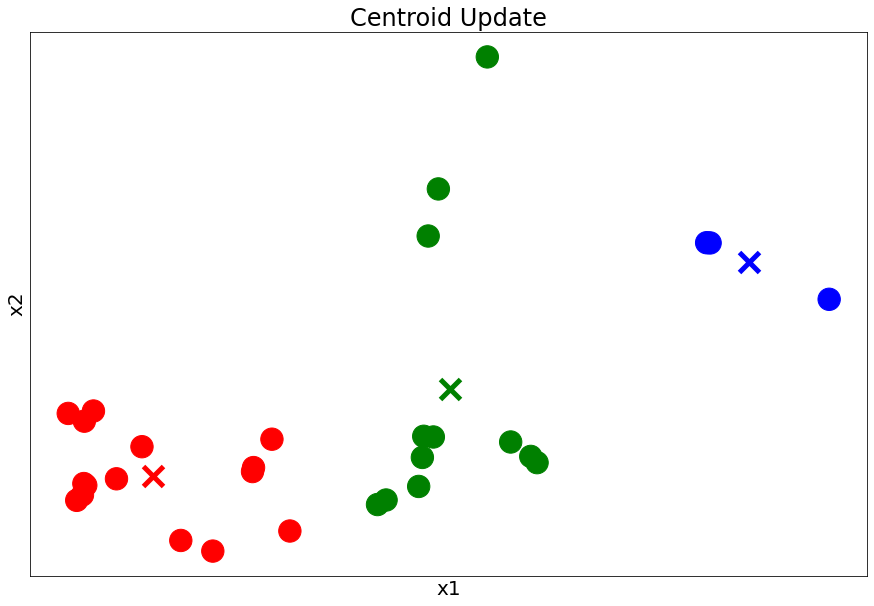

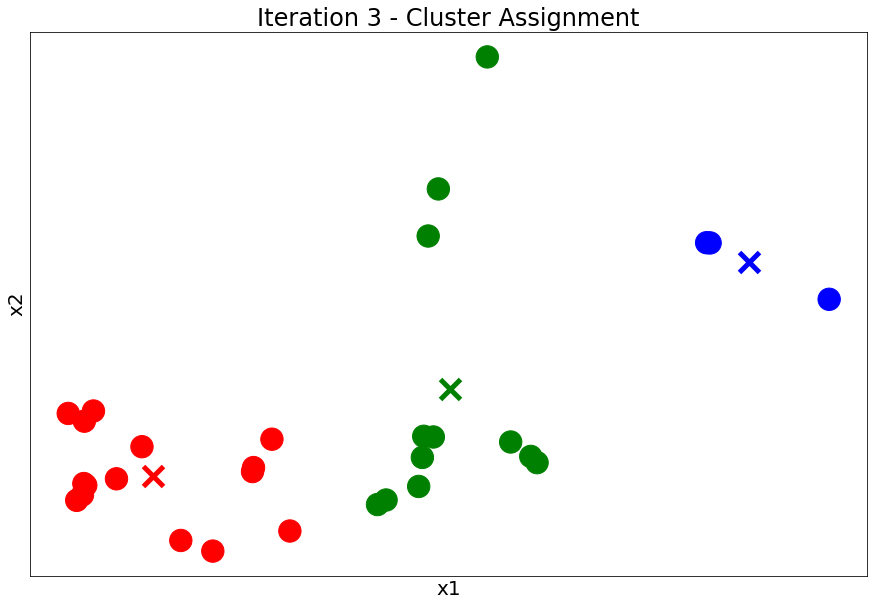

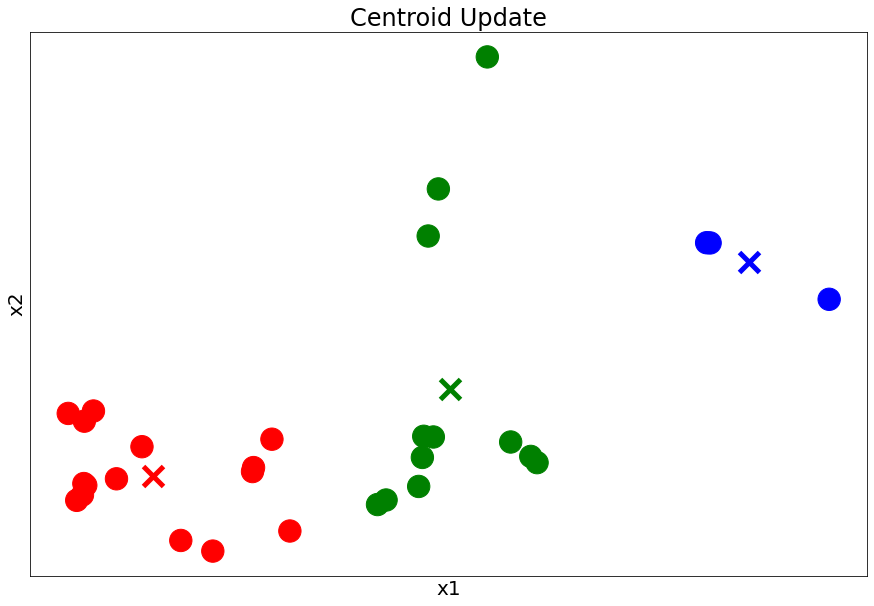

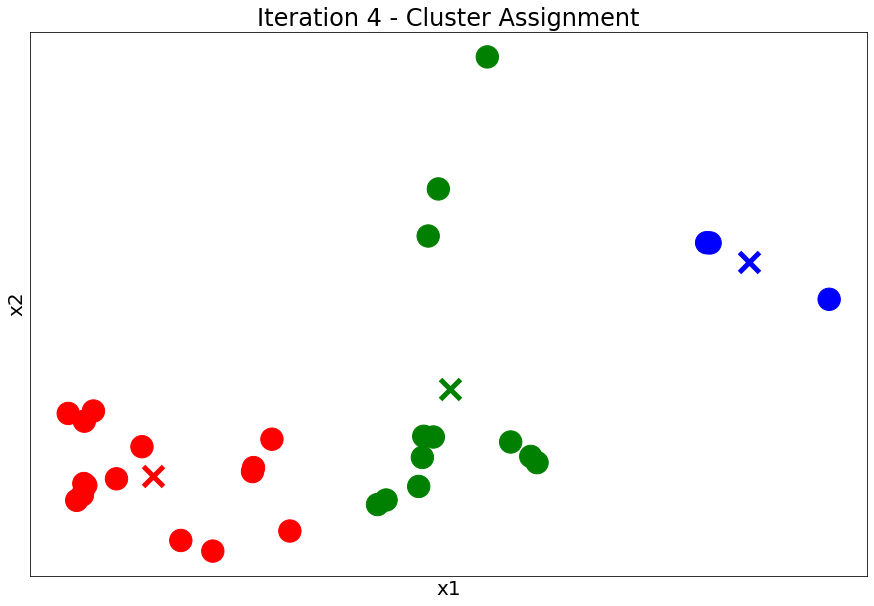

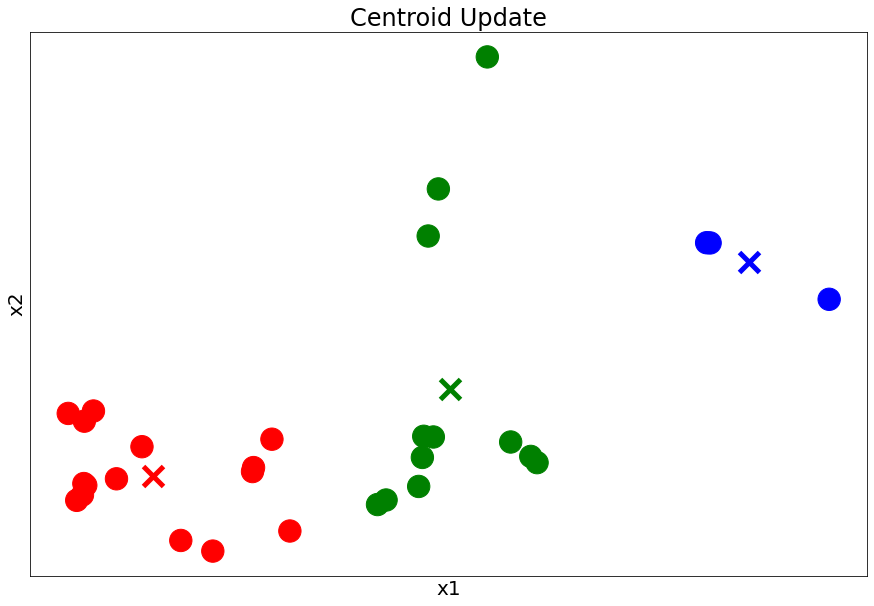

In [57]:
import random
#Initial Scatter plot
plot_points(figure_title="Scatter Plot of x2 vs x1")

#assigning 3 random centers
t=random.sample(range(df.shape[0]), 3)
centers=[[x1[t[0]],x2[t[0]]],[x1[t[1]],x2[t[1]]],[x1[t[2]],x2[t[2]]]]

#Iterating through to Update Clusters and Centroids
plot_points(centers,figure_title="Initialization")
number_of_iterations=4
for i in range(number_of_iterations):
    colors,class_of_points=assign_members(x1,x2,centers)
    title='Iteration {} - Cluster Assignment'.format(i+1)
    plot_points(centers,colors,figure_title=title)
    centers=update_centers(x1,x2,class_of_points)
    title="Centroid Update"
    plot_points(centers,colors,figure_title=title)

# Plotting Clusters on Map

Now as we have formed clusters of the places that lie close to each other, we will plot the coordinates of the places on a map for as the user to check them out

In [60]:
!pip install folium
import folium

In [77]:
color=[]
for i in colors:
    color.append('red' if i=='r' else ('blue' if i=='b' else 'green'))

In [78]:
mumbai_map=folium.Map(location=[19.0760, 72.8777],zoom_start=11)
toutist_places=folium.FeatureGroup()
for lat,long,c in zip(df.Lat,df.Long,color):
    toutist_places.add_child(folium.features.CircleMarker([lat,long],radius=5,color=c,fill=True,fill_color=c,fill_opacity=0.6))
for lat,long,cat,add in zip(df.Lat,df.Long,df.Category,df.Address):
    folium.Marker([lat,long],popup="Category:{0}\nAddress:{1}".format(cat,add)).add_to(mumbai_map)
mumbai_map.add_child(toutist_places)

From this we observe most famous tourist places in Mumbai lie in Souch east of the City and hence it'll be benefecial for the user to take up a hotel in that location